In [2]:
import os
import numpy as np
import scanpy as sc
import anndata as ad
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(5, 5)
plt.rcParams['figure.dpi'] = 200
sc.settings.verbosity = 3
sc.logging.print_versions()
#results_file = './write/results.h5ad'


%load_ext autoreload
%autoreload 2 

scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.4 scipy==1.3.2 pandas==0.25.3 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [3]:
import rpy2.rinterface_lib.callbacks
import logging
import warnings
from rpy2.robjects import pandas2ri
import anndata2ri


# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

In [4]:
%%R
# Load all the R libraries we will be using in the notebook
library(scran)
#library(RColorBrewer)
#library(slingshot)
#library(monocle)
#library(gam)
#library(clusterExperiment)
#library(ggplot2)
#library(plyr)
library(MAST)

# Dataloading

In [5]:
! pwd

/home/icb/carlo.dedonno/HPA


In [6]:
adatas = []

data_file = './data/MUC10101/raw_gene_bc_matrices/mm10/matrix.mtx'
barcode_file = './data/MUC10101/raw_gene_bc_matrices/mm10/barcodes.tsv'
gene_file = './data/MUC10101/raw_gene_bc_matrices/mm10/genes.tsv'

adata = sc.read(data_file, cache=True)
adata = adata.transpose()
#adata.X = adata.X.toarray()

barcodes = pd.read_csv(barcode_file, header=None, sep='\t')
genes = pd.read_csv(gene_file, header=None, sep='\t')

#Annotate data
barcodes.rename(columns={0:'barcode'}, inplace=True)
barcodes.set_index('barcode', inplace=True)
adata.obs = barcodes
adata.obs['tissue'] = 'PVN'
adata.obs['condition'] = 'Control'
genes.rename(columns={0:'gene_id', 1:'gene_symbol'}, inplace=True)
genes.set_index('gene_symbol', inplace=True)
adata.var = genes
adatas.append(adata)

##############################################################################################
data_file = './data/MUC10102/raw_gene_bc_matrices/mm10/matrix.mtx'
barcode_file ='./data/MUC10102/raw_gene_bc_matrices/mm10/barcodes.tsv'
gene_file ='./data/MUC10102/raw_gene_bc_matrices/mm10/genes.tsv'

adata = sc.read(data_file, cache=True)
adata = adata.transpose()
#adata.X = adata.X.toarray()

barcodes = pd.read_csv(barcode_file, header=None, sep='\t')
genes = pd.read_csv(gene_file, header=None, sep='\t')

#Annotate data
barcodes.rename(columns={0:'barcode'}, inplace=True)
barcodes.set_index('barcode', inplace=True)
adata.obs = barcodes
adata.obs['tissue'] = 'PVN'
adata.obs['condition'] = 'Stress'
genes.rename(columns={0:'gene_id', 1:'gene_symbol'}, inplace=True)
genes.set_index('gene_symbol', inplace=True)
adata.var = genes
adatas.append(adata)
adata = adatas[0].concatenate(adatas[1:])
print(adata)
#adata.var['gene_id'] = adata.var['gene_id-1']
#adata.var.drop(columns = ['gene_id-1', 'gene_id-0'], inplace=True)
#adata.obs.drop(columns=['sample_id'], inplace=True)
#adata.obs_names = [c.split("-")[0] for c in adata.obs_names]
#adata.obs_names_make_unique(join='_')

del adatas

... writing an h5ad cache file to speedup reading next time
... writing an h5ad cache file to speedup reading next time


Making variable names unique for controlled concatenation.


AnnData object with n_obs × n_vars = 1474560 × 27998 
    obs: 'batch', 'condition', 'tissue'
    var: 'gene_id'


In [7]:
print(adata.obs['condition'].value_counts())
print('')

Stress     737280
Control    737280
Name: condition, dtype: int64



# QC

In [8]:
# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)

/home/icb/carlo.dedonno/python/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


... storing 'condition' as categorical
... storing 'tissue' as categorical


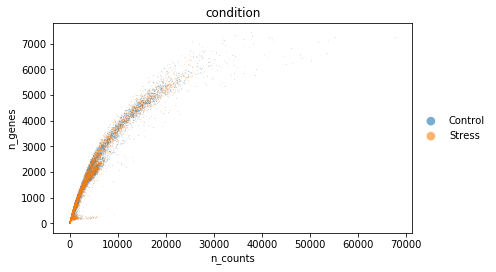

In [9]:
#Data quality summary plots
#plt.rcParams['figure.figsize'] = (10, 10)
p1 = sc.pl.scatter(adata, 'n_counts', 'n_genes', size=2, color='condition', alpha=0.6)

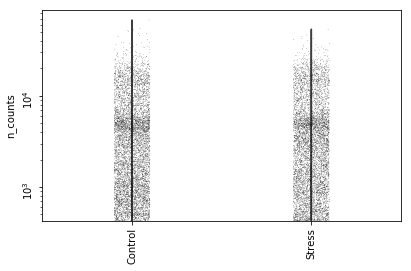

In [10]:
# Quality control - plot QC metrics
#Sample quality plots
t1 = sc.pl.violin(adata, 'n_counts', groupby='condition', size=0.5, log=True, cut=0, rotation=90)
#t2 = sc.pl.violin(adata, 'mt_frac', groupby='sample')

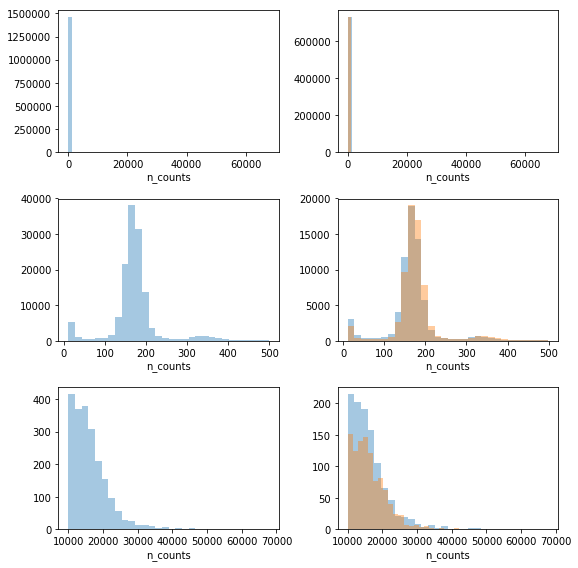

In [11]:
#Thresholding decision: counts
fig, ax = plt.subplots(3, 2, figsize=(8, 8))
sns.distplot(adata.obs['n_counts'], kde=False, ax=ax[0, 0])
sns.distplot(adata.obs['n_counts'][adata.obs['condition']=='Control'], kde=False, ax=ax[0, 1])
sns.distplot(adata.obs['n_counts'][adata.obs['condition']=='Stress'], kde=False, ax=ax[0, 1])

sns.distplot(adata.obs['n_counts'][(adata.obs['n_counts']> 10) & (adata.obs['n_counts']<500)], kde=False, bins=30, ax=ax[1, 0])
sns.distplot(adata.obs['n_counts'][adata.obs['condition']=='Control'][(adata.obs['n_counts']> 10) & (adata.obs['n_counts']<500)], kde=False, bins=30, ax=ax[1, 1])
sns.distplot(adata.obs['n_counts'][adata.obs['condition']=='Stress'][(adata.obs['n_counts']> 10) & (adata.obs['n_counts']<500)], kde=False, bins=30, ax=ax[1, 1])

sns.distplot(adata.obs['n_counts'][adata.obs['n_counts']>10000], kde=False, bins=30, ax=ax[2, 0])
sns.distplot(adata.obs['n_counts'][adata.obs['condition']=='Control'][adata.obs['n_counts']>10000], kde=False, bins=30, ax=ax[2, 1])
sns.distplot(adata.obs['n_counts'][adata.obs['condition']=='Stress'][adata.obs['n_counts']>10000], kde=False, bins=30, ax=ax[2, 1])
fig.tight_layout()

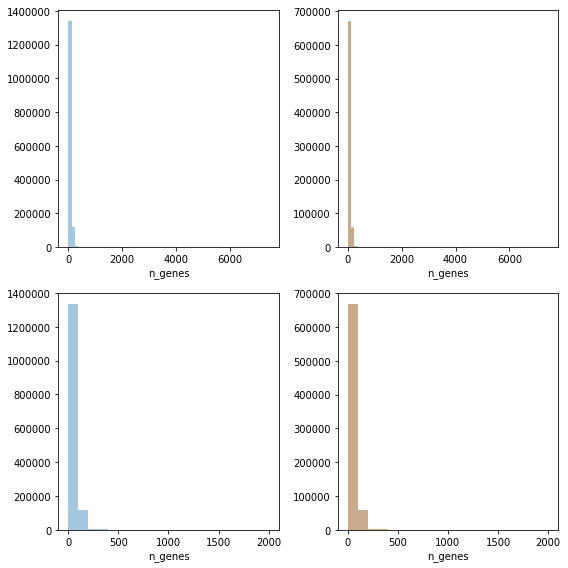

In [12]:
#Thresholding decision: genes
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
sns.distplot(adata.obs['n_genes'], kde=False, bins=60, ax=ax[0, 0])
sns.distplot(adata.obs['n_genes'][adata.obs['condition']=='Control'], kde=False, bins=60, ax=ax[0, 1])
sns.distplot(adata.obs['n_genes'][adata.obs['condition']=='Stress'], kde=False, bins=60, ax=ax[0, 1])

sns.distplot(adata.obs['n_genes'][adata.obs['n_genes']<2000], kde=False, bins=20, ax=ax[1, 0])
sns.distplot(adata.obs['n_genes'][adata.obs['condition']=='Control'][adata.obs['n_genes']<2000], kde=False, bins=20, ax=ax[1, 1])
sns.distplot(adata.obs['n_genes'][adata.obs['condition']=='Stress'][adata.obs['n_genes']<2000], kde=False, bins=20, ax=ax[1, 1])
fig.tight_layout()

In [12]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, max_counts = 300)
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))

Total number of cells: 1474560
filtered out 138398 cells that havemore than 300 counts
Number of cells after min count filter: 1336162


In [13]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_counts = 50)
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))

Total number of cells: 1336162
filtered out 1332104 cells that haveless than 50 counts
Number of cells after min count filter: 4058


In [14]:
print('Total number of genes: {:d}'.format(adata.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=5)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

Total number of genes: 27998
filtered out 20635 genes that are detectedin less than 5 cells
Number of genes after cell filter: 7363


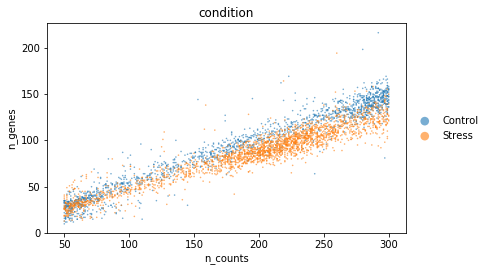

In [15]:
#Data quality summary plots
p1 = sc.pl.scatter(adata, 'n_counts', 'n_genes', size=10, color='condition', alpha=0.6)

# Normalization

In [16]:
#Perform a clustering for scran normalization in clusters
adata_pp = adata.copy()
sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15)
sc.pp.neighbors(adata_pp)
sc.tl.louvain(adata_pp, key_added='groups', resolution=0.5)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing PCA with n_comps = 15
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:02)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 3 clusters and added
    'groups', the cluster labels (adata.obs, categorical) (0:00:00)


In [17]:
sc.pp.normalize_per_cell(adata)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [27]:
#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata.X.T

In [ ]:
%%R -i data_mat -i input_groups -o size_factors

size_factors = computeSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

From cffi callback <function _processevents at 0x7fc649614a60>:
Traceback (most recent call last):
  File "/home/icb/carlo.dedonno/python/lib/python3.6/site-packages/rpy2/rinterface_lib/callbacks.py", line 262, in _processevents
    @ffi_proxy.callback(ffi_proxy._processevents_def,
KeyboardInterrupt


In [ ]:
# Visualize the estimated size factors
adata.obs['size_factors'] = size_factors

sc.pl.scatter(adata, 'size_factors', 'n_counts')
sc.pl.scatter(adata, 'size_factors', 'n_genes')

sns.distplot(size_factors, bins=50, kde=False)
plt.show()

In [18]:
#Keep the count data in a counts layer
adata.layers["counts"] = adata.X.copy()

In [19]:
#Normalize adata 
#adata.X /= adata.obs['size_factors'].values[:,None]
sc.pp.log1p(adata)

In [20]:
# Store the full data set in 'raw' as log-normalised data for statistical testing
adata.X = adata.X.toarray()

In [21]:
adata.raw = adata

In [22]:
from rpy2 import robjects
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()
def mast_de_bulk(adata, save):
    '''Compute differential expression with the MAST package by treatment covariate on the whole dataset'''
    
    #if groupby not in ['louvain_final', 'louvain_three']:
    #    raise NotImplementedError("This function is only implemented to be used with 'louvain_final' and 'louvain_three' group labels")
    
    # Define R function to run MAST analysis
    robjects.r('''
        mast_de_r <- function(adata, obs, var){
            #Prepare data sets for SingleCellExperiment data structure conversion
            #obs['wellKey'] = row.names(obs)
            #var['primerid'] = row.names(var)
            print('Deploying to R...')
            #Convert to SingleCellExperiment type
            #sca <- FromMatrix(exprsArray=data_mat, fData=var)
            sca <- SceToSingleCellAssay(adata, class = "SingleCellAssay")
            #Compute Gene detection rate
            colData(sca)$n_genes = scale(colData(sca)$n_genes)

            #Create a vector that will hold all the DE results

            count <- 0
            print('Begin computation...')
            #Define & run hurdle model
            zlmCond <- zlm(formula = ~condition + n_genes, sca=sca)
            summaryCond <- summary(zlmCond, doLRT='conditionStress')
            summaryDt <- summaryCond$datatable
            
            result <- merge(summaryDt[contrast=='conditionStress' & component=='H',.(primerid, `Pr(>Chisq)`)], #p-vals
                             summaryDt[contrast=='conditionStress' & component=='logFC', .(primerid, coef)], #logFC coefficients
                             by='primerid') 
                             
            #Correct for multiple testing (FDR correction) and filtering
            result[,FDR:=p.adjust(`Pr(>Chisq)`, 'fdr')]
            result[,coef:=result[,coef]/log(2)]
            names(result) <- c("gene", "pval", "log2FC", "qval")
            result = result[order(result$qval),]
            output <- result
                
            return(output)
        }
    ''')
    
    mast_de = robjects.globalenv['mast_de_r']
    

    
    #Create new Anndata object for use in MAST with non-batch corrected data as before
    adata_test = adata.copy()
    adata_test.X = adata.raw.X
    adata_test.obs['n_genes'] = (adata_test.X > 0).sum(1) 
    
    obs = adata_test.obs
    var = adata_test.var
    
    expr_dict = {adata_test.var.index[i]:{} for i in range(adata_test.shape[1])}
    expr_dict_stress = {adata_test.var.index[i]:{} for i in range(adata_test.shape[1])}
    expr_dict_ctrl = {adata_test.var.index[i]:{} for i in range(adata_test.shape[1])}
    expr = np.mean(adata_test.X, axis=0)
    print(expr.shape)
    expr_stress = np.mean(adata_test[(adata_test.obs['condition']=='Stress')].X, axis=0)
    expr_ctrl = np.mean(adata_test[(adata_test.obs['condition']=='Control')].X, axis=0)
    for i, gene in enumerate(adata_test.var.index):
        expr_dict[gene] = expr[i]
        expr_dict_stress[gene] = expr_stress[i]
        expr_dict_ctrl[gene] = expr_ctrl[i]
    
    result = mast_de(adata_test, obs, var)
    result
    writer = pd.ExcelWriter(save, engine='xlsxwriter')  
    result['meanExpr'] = [expr_dict[gene] for gene in result['gene'].values]
    result['meanExprStress'] = [expr_dict_stress[gene] for gene in result['gene'].values]
    result['meanExprCtrl'] = [expr_dict_ctrl[gene] for gene in result['gene'].values]
    result.to_excel(writer)

    writer.save()

    return result

In [23]:
de_bulk = mast_de_bulk(adata, save='./results/de_pituitary_ambient.xlsx')

(7363,)


NotImplementedError: Conversion 'py2rpy' not defined for objects of type '<class 'numpy.ndarray'>'